In [26]:
!pip install yfinance

https://pypi.org/project/yfinance/ 

In [27]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import copy

In [28]:
# def upload_prices_COTdates()


# def make_futureprice_matrix()

In [29]:
# Файл с датировкой отчетов СОТ
dates_url = 'https://raw.githubusercontent.com/ForestTiger-GH/COTRA/main/Даты%20отчетов%20СОТ.txt'
dates = pd.read_csv('https://raw.githubusercontent.com/ForestTiger-GH/COTRA/main/COTR_Dates.txt', parse_dates=True)

In [30]:
dates['Date'] = pd.to_datetime(dates['Date'])
# dates['fDate'] = dates['Date']

In [31]:
# Commodities
Wheat_SRW = yf.Ticker('ZW=F').history(period="max")
Wheat_SRW.index.name = 'Index'
Wheat_SRW['Date'] = Wheat_SRW.index
XXX = Wheat_SRW.append(dates)
Wheat_SRW = XXX.sort_values(by=['Date', 'Close'], ascending=True).ffill().drop_duplicates(subset=['Date']).merge(dates['Date'], how='right')

Soybeans = yf.Ticker('ZS=F').history(period="max")
Soybeans.index.name = 'Index'

In [32]:
# Financial
Canadian_Dollar = yf.Ticker('6C=F').history(period="max")
Canadian_Dollar.index.name = 'Index'
Canadian_Dollar['Date'] = Canadian_Dollar.index
XXX = Canadian_Dollar.append(dates)
Canadian_Dollar = XXX.sort_values(by=['Date', 'Close'], ascending=True).ffill().drop_duplicates(subset=['Date']).merge(dates['Date'], how='right')

British_Pound = yf.Ticker('6B=F').history(period="max")
British_Pound.index.name = 'Index'
British_Pound['Date'] = British_Pound.index

In [33]:
column_week_prefix = "Week_"
column_bilweek_prefix = "Bin_Long_Week_"
column_bisweek_prefix = "Bin_Short_Week_"
column_binweek_prefix = "Bin_Neut_Week_"
number_future_weeks = 26

target_price_count = 0.12
skip_count_less = 5.0

Wheat_SRW.drop('Dividends', axis=1, inplace=True)
Wheat_SRW.drop('Stock Splits', axis=1, inplace=True)

In [34]:
# matrix real

for i in range(number_future_weeks):
    Wheat_SRW[str(column_week_prefix + '%03d' % (i+1))] = ((Wheat_SRW['Close'].shift(-i-1)) / Wheat_SRW['Close'] - 1)


In [35]:
# matrix long

for i in range(number_future_weeks):
    Wheat_SRW[str(column_bilweek_prefix + '%03d' % (i+1))] = ((Wheat_SRW['Close'].shift(-i-1)) / Wheat_SRW['Close'] - 1)

    Wheat_SRW.loc[Wheat_SRW[str(column_bilweek_prefix + '%03d' % (i+1))] >= target_price_count, str(column_bilweek_prefix + '%03d' % (i+1))] = 1
    Wheat_SRW.loc[Wheat_SRW[str(column_bilweek_prefix + '%03d' % (i+1))] < target_price_count, str(column_bilweek_prefix + '%03d' % (i+1))] = 0

In [36]:
# matrix short

for i in range(number_future_weeks):
    Wheat_SRW[str(column_bisweek_prefix + '%03d' % (i+1))] = ((Wheat_SRW['Close'].shift(-i-1)) / Wheat_SRW['Close'] - 1)

    Wheat_SRW.loc[Wheat_SRW[str(column_bisweek_prefix + '%03d' % (i+1))]*(-1) <= target_price_count, str(column_bisweek_prefix + '%03d' % (i+1))] = 0
    Wheat_SRW.loc[Wheat_SRW[str(column_bisweek_prefix + '%03d' % (i+1))]*(-1) > target_price_count, str(column_bisweek_prefix + '%03d' % (i+1))] = 1

In [37]:
# # matrix neutral

# for i in range(number_future_weeks):
#     Wheat_SRW[str(column_binweek_prefix + '%03d' % (i+1))] = ((Wheat_SRW['Close'].shift(-i-1)) / Wheat_SRW['Close'] - 1)

#     Wheat_SRW.loc[((Wheat_SRW[str(column_binweek_prefix + '%03d' % (i+1))] > -target_price_count) & (Wheat_SRW[str(column_binweek_prefix + '%03d' % (i+1))] < target_price_count)), str(column_binweek_prefix + '%03d' % (i+1))] = 1
#     Wheat_SRW.loc[(Wheat_SRW[str(column_binweek_prefix + '%03d' % (i+1))] <= -target_price_count) & (Wheat_SRW[str(column_binweek_prefix + '%03d' % (i+1))] >= target_price_count), str(column_binweek_prefix + '%03d' % (i+1))] = 0

In [38]:
# # matrix neutral

# for i in range(number_future_weeks):
#     Wheat_SRW[str(column_binweek_prefix + '%03d' % (i+1))] = ((Wheat_SRW['Close'].shift(-i-1)) / Wheat_SRW['Close'] - 1)

#     Wheat_SRW.loc[abs(Wheat_SRW[str(column_binweek_prefix + '%03d' % (i+1))]) < target_price_count, str(column_binweek_prefix + '%03d' % (i+1))] = 1
#     Wheat_SRW.loc[abs(Wheat_SRW[str(column_binweek_prefix + '%03d' % (i+1))]) > target_price_count, str(column_binweek_prefix + '%03d' % (i+1))] = 0

In [39]:
matrix_long = Wheat_SRW.iloc[:, 6:].sort_index(axis=1).iloc[:, : number_future_weeks]
# matrix_neutral = Wheat_SRW.iloc[:, 7:].sort_index(axis=1).iloc[:, number_future_weeks : number_future_weeks*2]
matrix_short = Wheat_SRW.iloc[:, 6:].sort_index(axis=1).iloc[:, number_future_weeks : number_future_weeks*2]
matrix_real = Wheat_SRW.iloc[:, 6:].sort_index(axis=1).iloc[:, number_future_weeks*2 : number_future_weeks*3]

In [40]:
Wheat_SRW['Long'] = matrix_long.sum(axis=1)
Wheat_SRW['Short'] = matrix_short.sum(axis=1)
# Wheat_SRW['Neutral'] = matrix_neutral.sum(axis=1)
Wheat_SRW['Net'] = Wheat_SRW['Long'] - Wheat_SRW['Short']

In [41]:
Wheat_SRW['Long wS'] = Wheat_SRW['Long']
Wheat_SRW['Short wS'] = Wheat_SRW['Short']
# Wheat_SRW['Net wS'] = Wheat_SRW['Net']

Wheat_SRW.loc[Wheat_SRW['Long wS'] < skip_count_less, Wheat_SRW['Long wS']] = 0
Wheat_SRW.loc[Wheat_SRW['Short wS'] < skip_count_less, Wheat_SRW['Short wS']] = 0

Wheat_SRW['Net wS'] = Wheat_SRW['Long wS'] - Wheat_SRW['Short wS']
Wheat_SRW.loc[Wheat_SRW['Net wS'] < skip_count_less, Wheat_SRW['Net wS']] = 0

In [47]:
Wheat_SRW['Long wS'][50:55]

50     0.0
51    11.0
52     1.0
53     0.0
54     0.0
Name: Long wS, dtype: float64

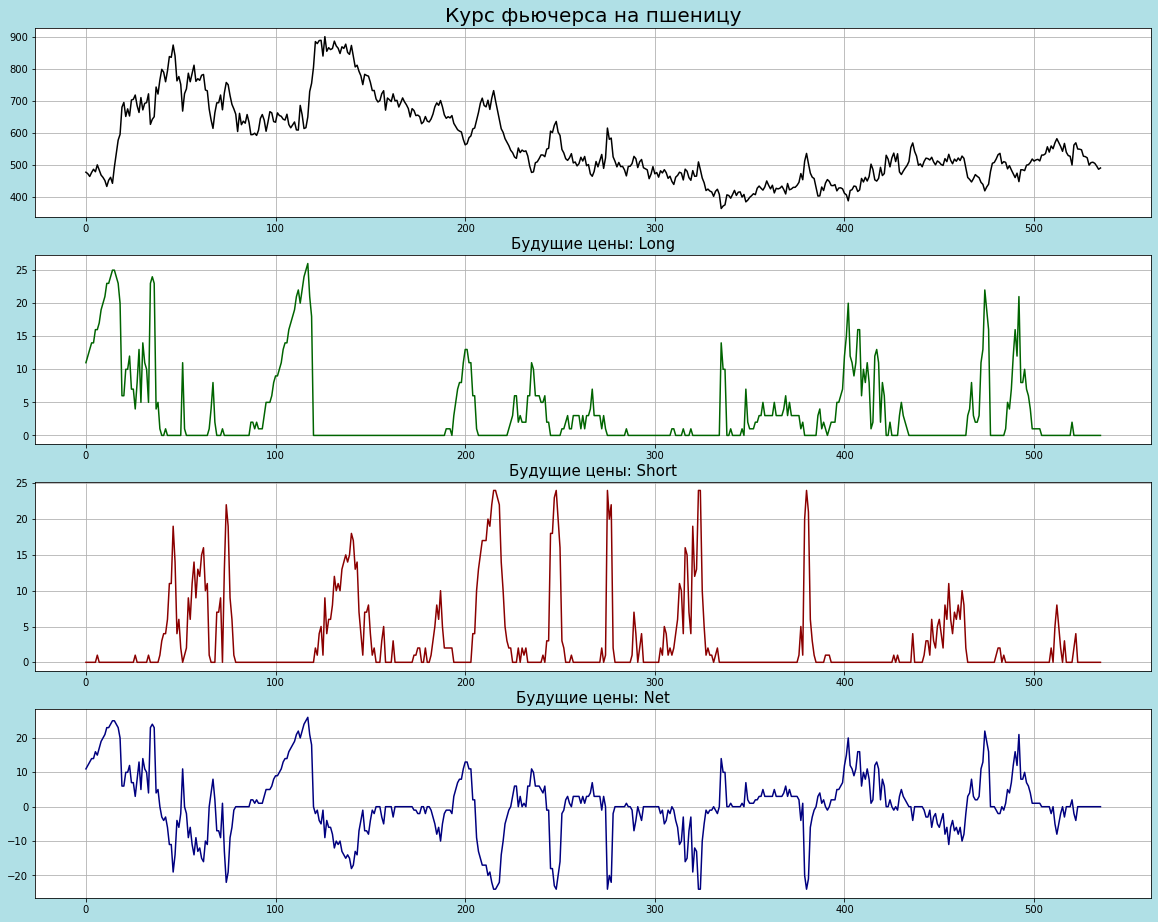

In [43]:
fig = plt.figure()
ax_1 = fig.add_subplot(4, 1, 1)
ax_1.grid()
ax_2 = fig.add_subplot(4, 1, 2)
ax_2.grid()
ax_3 = fig.add_subplot(4, 1, 3)
ax_3.grid()
ax_4 = fig.add_subplot(4, 1, 4)
ax_4.grid()
fig.set(facecolor = 'powderblue')

ax_1.set_title('Курс фьючерса на пшеницу', fontsize = 20)
ax_1.plot(Wheat_SRW['Close'], color='black')
ax_2.set_title('Будущие цены: Long', fontsize = 15)
ax_2.plot(Wheat_SRW['Long'], color='darkgreen')
ax_3.set_title('Будущие цены: Short', fontsize = 15)
ax_3.plot(Wheat_SRW['Short'], color='darkred')
ax_4.set_title('Будущие цены: Net', fontsize = 15)
ax_4.plot(Wheat_SRW['Net'], color='navy')

fig.set_figwidth(20)
fig.set_figheight(16)
fig.show()

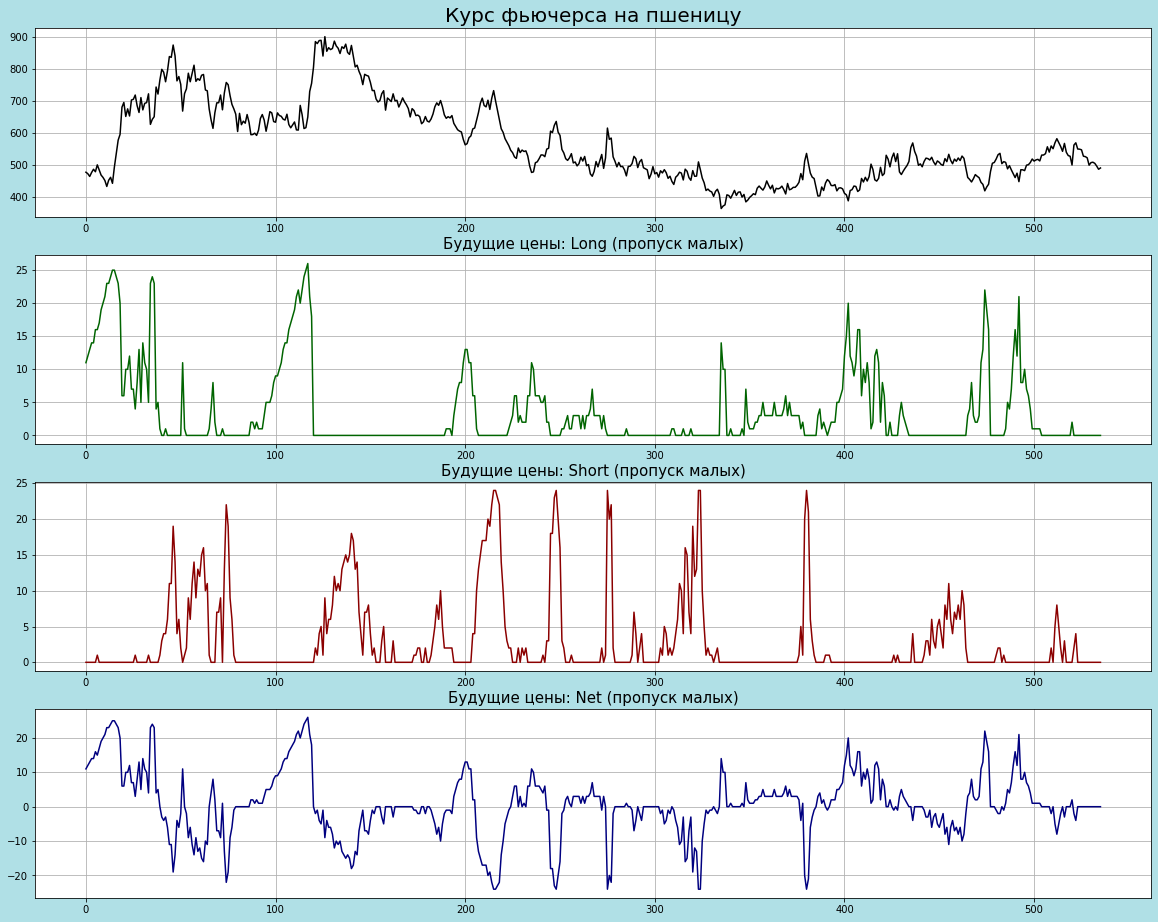

In [44]:
fig = plt.figure()
ax_1 = fig.add_subplot(4, 1, 1)
ax_1.grid()
ax_2 = fig.add_subplot(4, 1, 2)
ax_2.grid()
ax_3 = fig.add_subplot(4, 1, 3)
ax_3.grid()
ax_4 = fig.add_subplot(4, 1, 4)
ax_4.grid()
fig.set(facecolor = 'powderblue')

ax_1.set_title('Курс фьючерса на пшеницу', fontsize = 20)
ax_1.plot(Wheat_SRW['Close'], color='black')
ax_2.set_title('Будущие цены: Long (пропуск малых)', fontsize = 15)
ax_2.plot(Wheat_SRW['Long wS'], color='darkgreen')
ax_3.set_title('Будущие цены: Short (пропуск малых)', fontsize = 15)
ax_3.plot(Wheat_SRW['Short wS'], color='darkred')
ax_4.set_title('Будущие цены: Net (пропуск малых)', fontsize = 15)
ax_4.plot(Wheat_SRW['Net wS'], color='navy')

fig.set_figwidth(20)
fig.set_figheight(16)
fig.show()